In [18]:
from math import sqrt
import re
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline
from pylab import * 
from itertools import product 
from mltools.perfmeasures import *
import random 


In [9]:
ls = range(1,6) #length of kmer
ys = [1, 2, 4, 5, 6, 10, 15] #some threshold
region = "data/region25_out/region25"

### Run profile kernel

In [3]:
for l, y in product(ls, ys):
    print(">>> Working on parameters L={0}, Y={1}".format(l, y))
    !profkernel-core -o {region}.idfile -K -L {l} -Y {y} -i /usr/share/fastprofkernel/data/Amino.txt -g /usr/share/fastprofkernel/data/Globals.txt {region}.kernelinput > {region}_L{l}_Y{y}.mat 2> {region}_L{l}_Y{y}.mat.log  

>>> Working on parameters L=1, Y=1
>>> Working on parameters L=1, Y=2
>>> Working on parameters L=1, Y=4
>>> Working on parameters L=1, Y=5
>>> Working on parameters L=1, Y=6
>>> Working on parameters L=1, Y=10
>>> Working on parameters L=1, Y=15
>>> Working on parameters L=2, Y=1
>>> Working on parameters L=2, Y=2
>>> Working on parameters L=2, Y=4
>>> Working on parameters L=2, Y=5
>>> Working on parameters L=2, Y=6
>>> Working on parameters L=2, Y=10
>>> Working on parameters L=2, Y=15
>>> Working on parameters L=3, Y=1
>>> Working on parameters L=3, Y=2
>>> Working on parameters L=3, Y=4
>>> Working on parameters L=3, Y=5
>>> Working on parameters L=3, Y=6
>>> Working on parameters L=3, Y=10
>>> Working on parameters L=3, Y=15
>>> Working on parameters L=4, Y=1
>>> Working on parameters L=4, Y=2
>>> Working on parameters L=4, Y=4
>>> Working on parameters L=4, Y=5
>>> Working on parameters L=4, Y=6
>>> Working on parameters L=4, Y=10
>>> Working on parameters L=4, Y=15
>>> Working 

### Adding row/col counts to the matrices

In [4]:
row_count = !wc -l {region}_L{ls[0]}_Y{ys[0]}.mat 
row_count = int(row_count[0].split(" ")[0])
row_count

1098

In [5]:
for l, y in product(ls, ys):
    !echo "{row_count} {row_count}\n$(cat {region}_L{l}_Y{y}.mat)" > {region}_L{l}_Y{y}.2.mat

### Execute weka

In [4]:
for l, y in product(ls, ys):
    print(">>> Working on parameters L={0}, Y={1}".format(l, y))
    !java -Xmx5g -cp bin/wekaTobi.jar:bin/weka.jar: weka.classifiers.meta.CVParameterSelection -p 1 -t {region}.arff -x 5 -S 1 -W weka.classifiers.functions.SMO -- -C 1.0 -L 0.0010 -P 1.0E-12 -N 0 -V -1 -W 1 -K "weka.classifiers.functions.supportVector.CustomPrecomputedKernelMatrixKernelFast -M {region}_L{l}_Y{y}.2.mat" > {region}_L{l}_Y{y}.weka

>>> Working on parameters L=1, Y=1
>>> Working on parameters L=1, Y=2
>>> Working on parameters L=1, Y=4
>>> Working on parameters L=1, Y=5
>>> Working on parameters L=1, Y=6
>>> Working on parameters L=1, Y=10
>>> Working on parameters L=1, Y=15
>>> Working on parameters L=2, Y=1
>>> Working on parameters L=2, Y=2
>>> Working on parameters L=2, Y=4
>>> Working on parameters L=2, Y=5
>>> Working on parameters L=2, Y=6
>>> Working on parameters L=2, Y=10
>>> Working on parameters L=2, Y=15
>>> Working on parameters L=3, Y=1
>>> Working on parameters L=3, Y=2
>>> Working on parameters L=3, Y=4
>>> Working on parameters L=3, Y=5
>>> Working on parameters L=3, Y=6
>>> Working on parameters L=3, Y=10
>>> Working on parameters L=3, Y=15
>>> Working on parameters L=4, Y=1
>>> Working on parameters L=4, Y=2
>>> Working on parameters L=4, Y=4
>>> Working on parameters L=4, Y=5
>>> Working on parameters L=4, Y=6
>>> Working on parameters L=4, Y=10
>>> Working on parameters L=4, Y=15
>>> Working 

### extract confusion matrix from WEKA and compute standard error

In [10]:
def extract_confusion_matrix_instances(wekafile):
    """
    return list [(actual, predicted), (actual, predicted), ...]
    """
    dataLine = re.compile(r"\d+")
    instances = []
    with open(wekafile) as f: 
        for line in f.readlines():
            if dataLine.search(line): 
                actual, predicted = line.strip().split()[1:3]
                actual = actual[2:]
                predicted = predicted[2:]
                instances.append((actual, predicted))
    return instances            
                

In [11]:
def randsample(instances, fraction=0.5):
    return random.sample(instances, int(fraction*len(instances)))

In [12]:
def get_confusion_matrix(instances): 
    TP = FN = FP = TN = 0
    for actual, predicted in instances: 
        if actual == "positive":
            if predicted == "positive":
                TP += 1
            elif predicted == "negative":
                FN += 1
            else:
                assert False, "invalid predicted class"
        elif actual == "negative":
            if predicted == "positive":
                FP += 1
            elif predicted == "negative":
                TN += 1
            else:
                assert False, "invalid predicted class"
        else: 
            assert False, "invalid actual class"
    return (TP, FN, FP, TN)

In [13]:
def bootstrap(instances, iterations=1000, fraction=0.5):
    perfs = []
    for i in range(iterations):
        perfs.append(get_confusion_matrix(randsample(instances)))
    return perfs

In [14]:
def stderr(array):
    return np.std(array) / np.sqrt(len(array))

In [19]:
perf_dict = {}
for l, y in product(ls, ys):
    instances = extract_confusion_matrix_instances("{0}_L{1}_Y{2}.weka".format(region, l, y))
    perfs = bootstrap(instances)
    perf_dict[(l, y)] = perfs

### compare the parameters
#### Which measure to use?
* Accuracy: bad because data is unbalanced
* F-Measure: hard to interpret intuitievely
* MCC: good, easy to interpret and balanced
* Sensistivity, Specificity: good, give the user information about what they actually expect from the predictor

In [22]:
def make_df(f, standard_error = False):
    f_dict = {}
    for y in ys:
        f_dict[y] = {}
        for l in ls:
            perfs = []
            confusion_lines = perf_dict[(l, y)]
            for confusion_line in confusion_lines:
                perfs.append(f(*confusion_line))
            perf = np.mean(perfs)
            if standard_error:
                perf_se = stderr(perfs)
                f_dict[y][l] = (perf, perf_se)
            else: 
                f_dict[y][l] = perf
    return pd.DataFrame(f_dict)

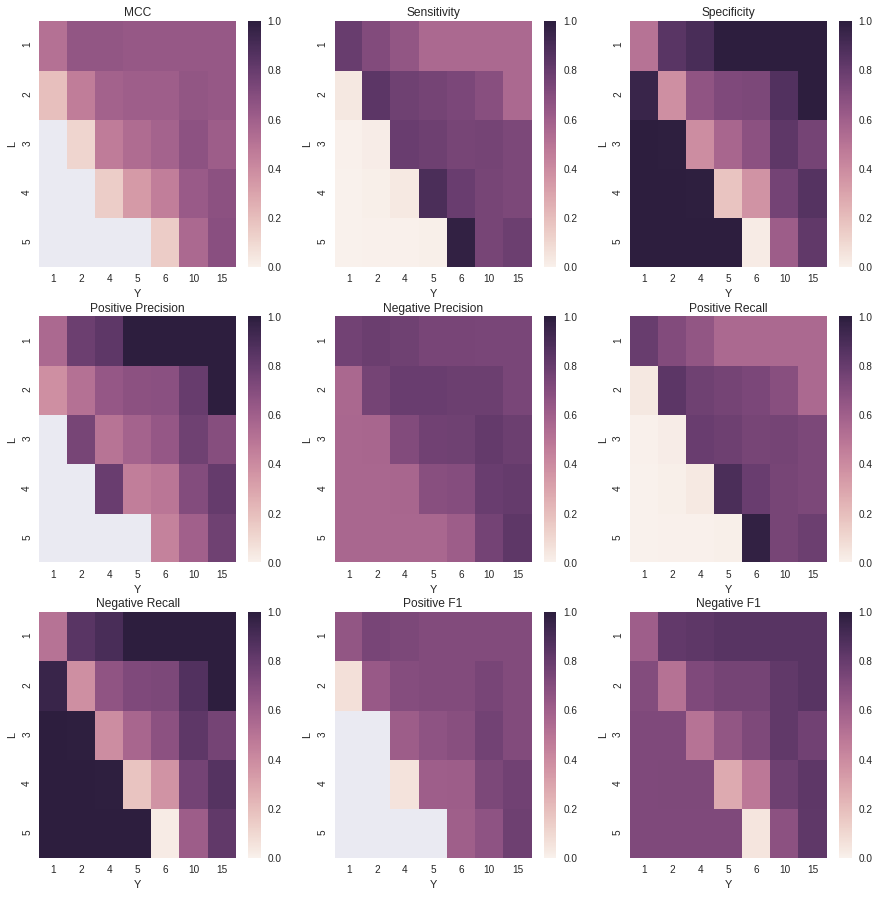

In [24]:
fig, grid = subplots(3, 3, figsize=(15, 15))

sns.heatmap(make_df(mcc), ax=grid[0][0], vmin=0, vmax=1)
grid[0][0].set_title("MCC")

sns.heatmap(make_df(sens), ax=grid[0][1], vmin=0, vmax=1)
grid[0][1].set_title("Sensitivity")

sns.heatmap(make_df(spec), ax=grid[0][2], vmin=0, vmax=1)
grid[0][2].set_title("Specificity")

sns.heatmap(make_df(prec_pos), ax=grid[1][0], vmin=0, vmax=1)
grid[1][0].set_title("Positive Precision")

sns.heatmap(make_df(prec_neg), ax=grid[1][1], vmin=0, vmax=1)
grid[1][1].set_title("Negative Precision")

sns.heatmap(make_df(recall_pos), ax=grid[1][2], vmin=0, vmax=1)
grid[1][2].set_title("Positive Recall")

sns.heatmap(make_df(recall_neg), ax=grid[2][0], vmin=0, vmax=1)
grid[2][0].set_title("Negative Recall")

sns.heatmap(make_df(f1_pos), ax=grid[2][1], vmin=0, vmax=1)
grid[2][1].set_title("Positive F1")

sns.heatmap(make_df(f1_neg), ax=grid[2][2], vmin=0, vmax=1)
grid[2][2].set_title("Negative F1")


for ax in grid.flatten():
    ax.set_xlabel("Y")
    ax.set_ylabel("L")
    
fig.savefig("wiki/eval25.png")

In [34]:
make_df(mcc, True)

,1,2,4,5,6,10,15
1,"(0.515467813596, 0.000317155987892)","(0.653563479896, 0.000477807604503)","(0.650410629383, 0.000495326657741)","(0.639567743547, 0.000548135077736)","(0.640127340668, 0.000557508544046)","(0.63946695018, 0.000561380961641)","(0.639642469696, 0.00057282042381)"
2,"(0.197810398297, 0.000443371731016)","(0.462454544445, 0.000313799165241)","(0.586672666511, 0.000387280793256)","(0.606548978236, 0.000414371551175)","(0.60643825557, 0.000392848760104)","(0.656026720267, 0.000471124986539)","(0.639697610019, 0.000575217079698)"
3,"(nan, nan)","(0.110611732469, 0.000561147161677)","(0.468626940615, 0.000265343035799)","(0.541153191559, 0.000342123109152)","(0.583922534385, 0.000378444328138)","(0.670211825055, 0.00045851330387)","(0.613698101096, 0.000422052115683)"
4,"(nan, nan)","(nan, nan)","(0.140858719826, 0.000521899742442)","(0.341706010648, 0.000356320438667)","(0.458949953911, 0.000269941547841)","(0.626014612588, 0.000426135156264)","(0.676708374621, 0.000470282256577)"
5,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(0.148223259594, 0.00043743061676)","(0.553673060241, 0.000331650299244)","(0.683801028613, 0.000463794918115)"


In [35]:
make_df(sens, True)

,1,2,4,5,6,10,15
1,"(0.79730703515, 0.000586476154912)","(0.707975450678, 0.00066938779165)","(0.652138316668, 0.000694685324367)","(0.55118955677, 0.000686657895602)","(0.551944633167, 0.000698596087042)","(0.551692113323, 0.000703584725134)","(0.551483539112, 0.000712168143667)"
2,"(0.0376488999108, 0.000271932860796)","(0.837430933079, 0.000536417046708)","(0.776814860009, 0.000588003275698)","(0.751327094752, 0.000632642406085)","(0.737362663434, 0.000609564756696)","(0.692012192422, 0.000663952578797)","(0.551737141199, 0.000730803308643)"
3,"(0.00605770702798, 0.000116004967901)","(0.0188278344368, 0.000200166507164)","(0.791578303947, 0.000585056957975)","(0.778442016034, 0.0005967208251)","(0.748751272288, 0.000611473495758)","(0.751954242636, 0.000633115190842)","(0.728314516627, 0.0006660918666)"
4,"(0.0, 0.0)","(0.00826940569191, 0.000130936972647)","(0.0312706387125, 0.000247414168755)","(0.897633997178, 0.000428493609471)","(0.796020586397, 0.000585894530641)","(0.74920511518, 0.000618725729427)","(0.731090938199, 0.000621694323457)"
5,"(0.0, 0.0)","(0.00407743434305, 9.30974937213e-05)","(0.00412206587696, 9.24530273253e-05)","(0.00843032129397, 0.000134830965591)","(0.979084990091, 0.000198629940744)","(0.747203627074, 0.000640778432783)","(0.78505043776, 0.000573524763275)"


In [27]:
make_df(spec)

,1,2,4,5,6,10,15
1,0.504303,0.846897,0.899997,1.000000,1.000000,1.000000,1.000000
2,0.953214,0.385084,0.663603,0.721361,0.732965,0.867251,1.000000
3,1.000000,0.995139,0.393892,0.568335,0.678234,0.832549,0.754717
4,1.000000,1.000000,0.993738,0.175014,0.370085,0.759559,0.862459
5,1.000000,1.000000,1.000000,0.998409,0.025715,0.613542,0.824040


In [36]:
make_df(prec_pos, True)

,1,2,4,5,6,10,15
1,"(0.554774536179, 0.000582619672108)","(0.782130137632, 0.000658739726862)","(0.834647677679, 0.000608741478702)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
2,"(0.384364133569, 0.00226416490137)","(0.512561865284, 0.000575121781495)","(0.641028013276, 0.000627199317125)","(0.676034315583, 0.000679279293006)","(0.680550327216, 0.000654010349015)","(0.80155574747, 0.000613495797165)","(1.0, 0.0)"
3,"(nan, nan)","(0.749437518038, 0.00467648374998)","(0.5034335674, 0.000566638794068)","(0.582467168012, 0.000633066515508)","(0.642780834804, 0.000653246607796)","(0.776837075838, 0.000624405214601)","(0.697037217171, 0.000661466731901)"
4,"(nan, nan)","(nan, nan)","(0.795275073538, 0.00327330710817)","(0.457088335284, 0.000523193012843)","(0.495121738659, 0.000581254190799)","(0.706960862381, 0.000646012385151)","(0.804772003475, 0.000612541465922)"
5,"(nan, nan)","(nan, nan)","(nan, nan)","(nan, nan)","(0.438308416236, 0.000470998571175)","(0.599081474028, 0.000622045233071)","(0.77530497774, 0.000595793056951)"


In [29]:
make_df(prec_neg)

,1,2,4,5,6,10,15
1,0.762528,0.788864,0.769685,0.742293,0.742581,0.741391,0.742076
2,0.560916,0.754179,0.793590,0.789435,0.783413,0.784195,0.741884
3,0.565286,0.567292,0.708884,0.768290,0.777319,0.812344,0.781916
4,0.563543,0.565989,0.569609,0.688250,0.700433,0.796379,0.805229
5,0.562993,0.564981,0.564005,0.564905,0.612060,0.758485,0.832130


In [30]:
make_df(recall_pos)

,1,2,4,5,6,10,15
1,0.797307,0.707975,0.652138,0.551190,0.551945,0.551692,0.551484
2,0.037649,0.837431,0.776815,0.751327,0.737363,0.692012,0.551737
3,0.006058,0.018828,0.791578,0.778442,0.748751,0.751954,0.728315
4,0.000000,0.008269,0.031271,0.897634,0.796021,0.749205,0.731091
5,0.000000,0.004077,0.004122,0.008430,0.979085,0.747204,0.785050


In [31]:
make_df(recall_neg)

,1,2,4,5,6,10,15
1,0.504303,0.846897,0.899997,1.000000,1.000000,1.000000,1.000000
2,0.953214,0.385084,0.663603,0.721361,0.732965,0.867251,1.000000
3,1.000000,0.995139,0.393892,0.568335,0.678234,0.832549,0.754717
4,1.000000,1.000000,0.993738,0.175014,0.370085,0.759559,0.862459
5,1.000000,1.000000,1.000000,0.998409,0.025715,0.613542,0.824040


In [32]:
make_df(f1_pos)

,1,2,4,5,6,10,15
1,0.654094,0.742976,0.731954,0.710414,0.711033,0.710820,0.710640
2,0.068460,0.635719,0.702222,0.711474,0.707618,0.742554,0.710836
3,NaN,NaN,0.615266,0.666144,0.691529,0.763987,0.712112
4,NaN,NaN,0.060064,0.605553,0.610302,0.727272,0.765977
5,NaN,NaN,NaN,NaN,0.605389,0.664788,0.779976


In [33]:
make_df(f1_neg)

,1,2,4,5,6,10,15
1,0.606859,0.816723,0.829645,0.852006,0.852193,0.851408,0.851856
2,0.706117,0.509568,0.722620,0.753693,0.757203,0.823523,0.851734
3,0.722162,0.722509,0.506131,0.653148,0.724237,0.822196,0.767921
4,0.720737,0.722744,0.724025,0.278803,0.484000,0.777394,0.832756
5,0.720281,0.721911,0.721111,0.721437,0.049290,0.678159,0.827954
